In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from models.convolutional_vae_v2 import ConvolutionalVAEV2 
from models.convolutional_vae_v2 import preprocess_grid as preprocess_vaev2, postprocess_grid as postprocess_vaev2
from models.convolutional_vqvae import ConvolutionalVQVAE
from models.convolutional_vqvae import preprocess_grid as preprocess_vq, postprocess_grid as postprocess_vq
from models.fully_connected_vae import FullyConnectedVAE
from models.ppca_pipeline import preprocess_grid as preprocess_ppca_into_vae, postprocess_grid as postprocess_ppca_into_vae
from models.ppca_pipeline import get_compression_functions as get_ppca_into_vae_compresison_functions
from models.vq_pipeline import preprocess_grid as preprocess_vq_into_vae, postprocess_grid as postprocess_vq_into_vae
from models.vq_pipeline import get_compression_functions as get_vq_into_vae_compression_functions
from models.attention_solver import AttentionSolver

from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=128,
    feature_dim=[8, 8]
).to(device)

model_name="conv_vaev2_128_b1"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vaev2,
    postprocess_fn=postprocess_vaev2,
)
model_type = "vae"

In [ ]:
model = ConvolutionalVQVAE(
    in_channels=10, 
    starting_filters=64, 
    num_embeddings=256,
    embedding_dim=64,
    commitment_cost=0.25
).to(device)

model_name = "conv_vqvae_6x6x64_b2"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq,
    postprocess_fn=postprocess_vq,
)
model_type = "vq"

In [ ]:
input_dim = 6*6*64
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

model_name = "vq_vae_64_b1"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_vq_into_vae_compression_functions('../../checkpoints/conv_vqvae_6x6x64_b2.pt')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_vq_into_vae,
    postprocess_fn=postprocess_vq_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [ ]:
n_components = 128

input_dim = n_components
model = FullyConnectedVAE(
    input_dim=input_dim,
    hidden_dim=1024,
    latent_dim=64
).to(device)

model_name = "ppca128_vae_64_b5"
checkpoint = torch.load(f'../../checkpoints/{model_name}.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

compress_fn, decompress_fn = get_ppca_into_vae_compresison_functions(f'../../checkpoints/ppca_{n_components}.pkl')

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_ppca_into_vae,
    postprocess_fn=postprocess_ppca_into_vae,
    compress_fn=compress_fn,
    decompress_fn=decompress_fn,
)
model_type = "vae"

In [3]:
def grid_to_latent(pipeline: Pipeline, grid, model_type="vq"):
    grid = pipeline.preprocess_and_compress(grid)
    z = grid
    if model_type == 'vq':
        z = pipeline.encode(grid.unsqueeze(0).to(device))
    else:
        z, _ = pipeline.encode(grid.unsqueeze(0).to(device))
    
    z_size = z.size()
    z_flat = z.view(z.size(0), -1)

    return z_flat, z_size

def latent_to_grid(pipeline: Pipeline, z, expected_output, model_type="vq"):
    decoded = z
    if model_type == 'vq':
        z_quantized, _, _ = pipeline.model.quantize(z.to(device))
        decoded = pipeline.decode(z_quantized)
    else:
        decoded = pipeline.decode(z.unsqueeze(0).to(device))
        
    return pipeline.decompress_and_postprocess(decoded.squeeze(0), expected_output)

In [4]:
from utils.load_data import get_grids

training_data, validation_data  = get_grids(filepath="../../data/training")

In [11]:
import torch.nn as nn

first_task = next(iter(training_data.values()))
first_input, _ = first_task['train'][0]

_, z_size = grid_to_latent(pipeline, first_input, model_type)

latent_dim = torch.prod(torch.tensor(z_size)).item()
hidden_dim = 64

solver = AttentionSolver(latent_dim=latent_dim, hidden_dim=hidden_dim)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-4, weight_decay=1e-3)

In [12]:
# --- Training Loop ---
max_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(1, max_epochs):
    solver.train()
    epoch_loss = 0.0
    num_tasks = 0

    for puzzle_id, task in training_data.items():
        # Current example becomes the "test" example

        num_tasks+=1
        train_inputs, train_outputs = zip(*task['train'])
        test_input, test_output = task['test'][0]
        
        z_train_inputs = torch.stack([grid_to_latent(pipeline, grid, model_type)[0] for grid in train_inputs]).squeeze(1)
        z_train_outputs = torch.stack([grid_to_latent(pipeline, grid, model_type)[0] for grid in train_outputs]).squeeze(1)

        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)
        z_test_output, _ = grid_to_latent(pipeline, test_output, model_type)
        
        predicted_latent, _ = solver(z_test_input, z_train_inputs, z_train_outputs)

        loss = loss_fn(predicted_latent, z_test_output)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_train_loss = epoch_loss / num_tasks
    
    solver.eval()
    epoch_loss = 0.0
    num_tasks = 0

    for puzzle_id, task in validation_data.items():
        # Current example becomes the "test" example
        num_tasks+=1
        train_inputs, train_outputs = zip(*task['train'])
        test_input, test_output = task['test'][0]
        
        z_train_inputs = torch.stack([grid_to_latent(pipeline, grid, model_type)[0] for grid in train_inputs]).squeeze(1)
        z_train_outputs = torch.stack([grid_to_latent(pipeline, grid, model_type)[0] for grid in train_outputs]).squeeze(1)

        z_test_input, _ = grid_to_latent(pipeline, test_input, model_type)
        z_test_output, _ = grid_to_latent(pipeline, test_output, model_type)
        
        predicted_latent, _ = solver(z_test_input, z_train_inputs, z_train_outputs)

        loss = loss_fn(predicted_latent, z_test_output)

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_val_loss = epoch_loss / num_tasks
    print(f"Epoch {epoch}: Training loss {avg_train_loss}, Validation loss {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), f"../../checkpoints/attention_solver_{latent_dim}_{hidden_dim}_{model_name}.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping.")
            break

Epoch 1: Training loss 4.888233836094538, Validation loss 4.872441744804382
Epoch 2: Training loss 4.245173490444819, Validation loss 4.768050398826599
Epoch 3: Training loss 3.8765740861495335, Validation loss 4.690505409240723
Epoch 4: Training loss 3.5884465356667836, Validation loss 4.635749473571777
Epoch 5: Training loss 3.36079031765461, Validation loss 4.592561668157577
Epoch 6: Training loss 3.184635654091835, Validation loss 4.56304667532444
Epoch 7: Training loss 3.037207998633385, Validation loss 4.530861088037491
Epoch 8: Training loss 2.9065995872020722, Validation loss 4.516977689266205
Epoch 9: Training loss 2.7943502883116405, Validation loss 4.487669356465339
Epoch 10: Training loss 2.681731437643369, Validation loss 4.481174348592758
Epoch 11: Training loss 2.5863797559340793, Validation loss 4.470683408975601
Epoch 12: Training loss 2.500135453144709, Validation loss 4.467070004940033
Epoch 13: Training loss 2.414548990925153, Validation loss 4.4494836497306824
Epoc

In [13]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

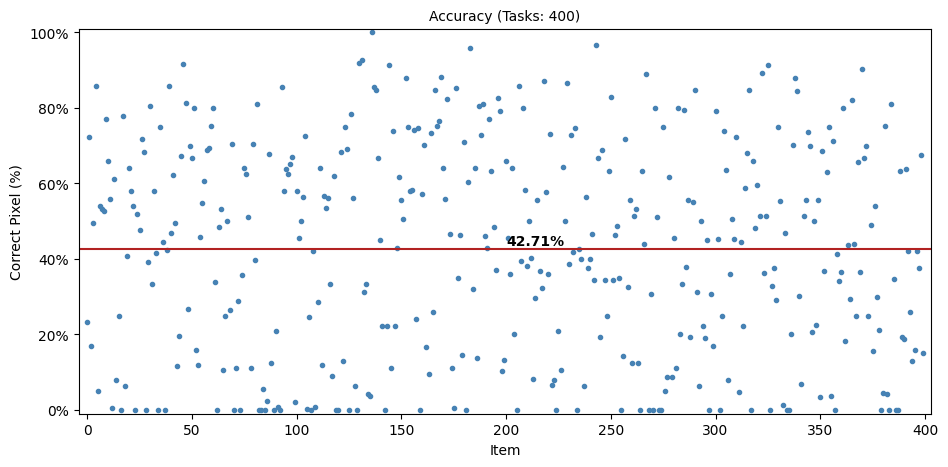

Number of 100% Correct: 1
Number of 90%+ Correct: 9
Number of 80%+ Correct: 40
Number of 70%+ Correct: 83


In [18]:
solved_puzzles = []

def compute_accuracy(original, decoded):
        correct = (original == decoded)
        accuracy = correct.mean().item()
        is_perfect = accuracy == 1.0
        return accuracy, is_perfect

accuracies = []    

# counter = 0
for puzzle_id, task in data.items():
    # if counter >= 10:
    #      break
    # counter +=1
    train_inputs, train_outputs = zip(*task['train'])
    test_input, test_output = task['test'][0]

    z_train_inputs = torch.stack([grid_to_latent(pipeline, grid, model_type)[0] for grid in train_inputs]).squeeze(1)
    z_train_outputs = torch.stack([grid_to_latent(pipeline, grid, model_type)[0] for grid in train_outputs]).squeeze(1)
    z_test_input, z_size = grid_to_latent(pipeline, test_input, model_type)
    
    z_pred, _ = solver(z_test_input, z_train_inputs, z_train_outputs)
    z_pred = z_pred.view(*z_size).unsqueeze(0)
    pred = latent_to_grid(pipeline, z_pred, test_output, model_type)[0]

    original = test_output
    acc, perfect = compute_accuracy(pred, original)
    accuracies.append(acc)

#     if perfect:
#         solved_puzzles.append(puzzle_id)

#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#         draw_grid(axes[0], pred, f"Puzzle {puzzle_id} Predicted output")
#         draw_grid(axes[1], original, f"Puzzle {puzzle_id} Original output")

mean = np.mean(accuracies)

ig, ax = plt.subplots(figsize=(11,5))
plt.plot(accuracies, color='steelblue', marker='.', linewidth=0)
plt.axhline(mean, xmax = len(accuracies), color='firebrick')
plt.title(f'Accuracy (Tasks: {len(accuracies)})', size='medium')
plt.xlabel('Item')
plt.ylabel('Correct Pixel (%)')
plt.text(len(accuracies)/2, mean+0.01, f'{(mean*100).round(2)}%', size='medium', weight='bold')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
plt.ylim(-0.01, 1.01)
plt.margins(x=0.01)
plt.show()

print(f'Number of 100% Correct: {accuracies.count(1)}')
print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in accuracies)}')
print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in accuracies)}')
print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in accuracies)}')
    